# Задание 8. Кластеризация точек.

Сгенерируйте несколько датасетов, состоящих из точек на плоскости по аналогии с этим примером из документации или вручную:

1) в виде двух параллельных отрезков,

2) в виде "восьмёрки" (две касающиеся окружности),

3) в виде отрезка, пересекающего два круга,

4) свой вариант.

Количество точек не менее 1000. Для каждого набора точек выбрать пару алгоритмов с хорошо интерпретируемыми, но различными результатами и алгоритм с "плохим" разбиением, объяснить результаты.

## 0. Импорт библиотек, кастомные функции

In [106]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, v_measure_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster, datasets
import random

np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

Константы.

In [107]:
SEED = 42
RANGE = (-1, 1)
N_SAMPLES = 1500
FIGSIZE = (5, 10)
MULTIPLOT_FIGZSIZE = (FIGSIZE[0] * 3 + 2, FIGSIZE[1])

Отрисовка датасета без раскраски.

In [108]:
def create_plot_for_original_data(some_noisy_df):
  _, ax = plt.subplots(figsize=FIGSIZE)
  plt.scatter(data=some_noisy_df, x='x', y='y')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.grid(True)

Получение меток для датасета разными алгоритмами кластеризации.

In [109]:
def get_labels(noisy_df):
  hierarchial_labels = AgglomerativeClustering(n_clusters=2).fit_predict(noisy_df)
  kmeans_labels = KMeans(n_clusters=2, n_init=100, random_state=SEED).fit_predict(noisy_df)
  dbscan_labels = DBSCAN(eps=0.2).fit_predict(noisy_df)

  noisy_df['hierarchial_labels'] = hierarchial_labels
  noisy_df['kmeans_labels'] = kmeans_labels
  noisy_df['dbscan_labels'] = dbscan_labels

Отрисовка датасета с раскраской.

In [110]:
def create_plot_for_clusters(noisy_df_with_labels):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=MULTIPLOT_FIGZSIZE)

  ax1.scatter(data=noisy_df_with_labels, x='x', y='y', c='hierarchial_labels') 
  ax1.grid(True)
  ax1.set_title("AgglomerativeClustering")
  ax1.set_xlabel("x")
  ax1.set_ylabel("y");

  ax2.scatter(data=noisy_df_with_labels, x='x', y='y', c='kmeans_labels')   
  ax2.grid(True)
  ax2.set_title("KMeans")
  ax2.set_xlabel("x")
  ax2.set_ylabel("y");

  ax3.scatter(data=noisy_df_with_labels, x='x', y='y', c='dbscan_labels')   
  ax3.grid(True)
  ax3.set_title("DBSCAN")
  ax3.set_xlabel("x")
  ax3.set_ylabel("y");

Подсчет и вывод метрики силуэт.

In [111]:
def count_and_display_metrics(noisy_df_with_labels, to_count_dbscan=True):
  silhouette_score_AC = silhouette_score(noisy_df_with_labels[['x', 'y']], noisy_df_with_labels['hierarchial_labels'])
  silhouette_score_KM = silhouette_score(noisy_df_with_labels[['x', 'y']], noisy_df_with_labels['kmeans_labels'])
  if to_count_dbscan:
    silhouette_score_D = silhouette_score(noisy_df_with_labels[['x', 'y']], noisy_df_with_labels['dbscan_labels'])
    metrics_df = pd.DataFrame({'silhouette score': [silhouette_score_AC, silhouette_score_KM, silhouette_score_D]},
                                index=['AgglomerativeClustering', 'KMeans', 'DBSCAN'])
  else:
    metrics_df = pd.DataFrame({'silhouette score': [silhouette_score_AC, silhouette_score_KM]},
                                index=['AgglomerativeClustering', 'KMeans'])
  display(metrics_df)

## Датасет в виде двух параллельных отрезков

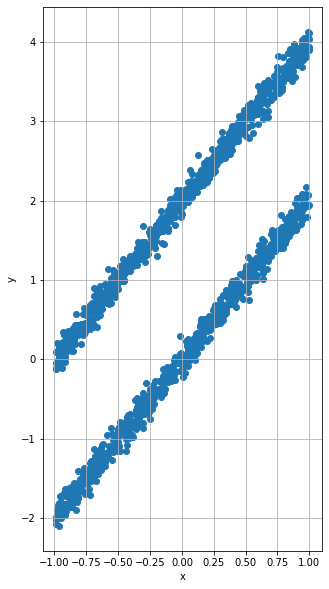

In [112]:
def target_function_segment(x):
    return 2 * x

def generate_samples_segment(to_do_shuffle=True):
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function_segment(x) + np.random.normal(scale=0.1, size=N_SAMPLES)
    if to_do_shuffle:
      y[len(y) // 2::] += 2
    return x.reshape(-1, 1), y

X, y = generate_samples_segment()
segments_df = pd.DataFrame({'x': X[:, 0], 'y': y})

create_plot_for_original_data(segments_df)

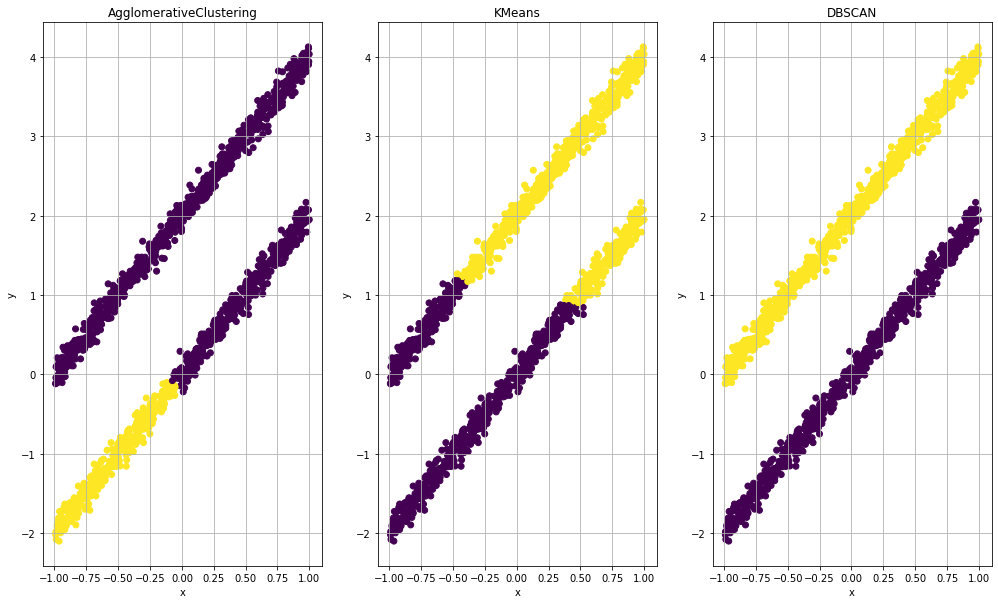

In [113]:
get_labels(segments_df)
create_plot_for_clusters(segments_df)

In [114]:
count_and_display_metrics(segments_df)

,silhouette score
AgglomerativeClustering,0.469392
KMeans,0.531281
DBSCAN,0.305171


Мои "места" (с опорой на графики):
1. DBSCAN
2. KMeans
3. AgglomerativeClustering

"Места" силуэта:
1. KMeans
2. AgglomerativeClustering
3. DBSCAN

Вывод: DBSCAN способен находить более "хитрые" кластеры.

## Датасет в виде "восьмёрки" (две касающиеся окружности)

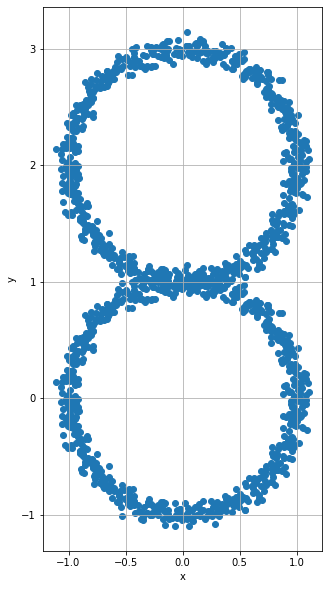

In [115]:
noisy_circles = datasets.make_circles(n_samples=N_SAMPLES, factor=0.5, noise=0.05, random_state=SEED)
df = pd.DataFrame({'x': noisy_circles[0][:, 0], 'y': noisy_circles[0][:, 1], 'num': noisy_circles[1]})

first_curcle_df = df[df['num'] == 0]
second_curcle_df = df[df['num'] == 0]
# second_curcle_df.loc[:, 'x'] += 2
second_curcle_df.loc[:, 'y'] += 2

curcle_df = pd.concat([first_curcle_df, second_curcle_df], ignore_index=True).drop(columns=['num'])

create_plot_for_original_data(curcle_df)

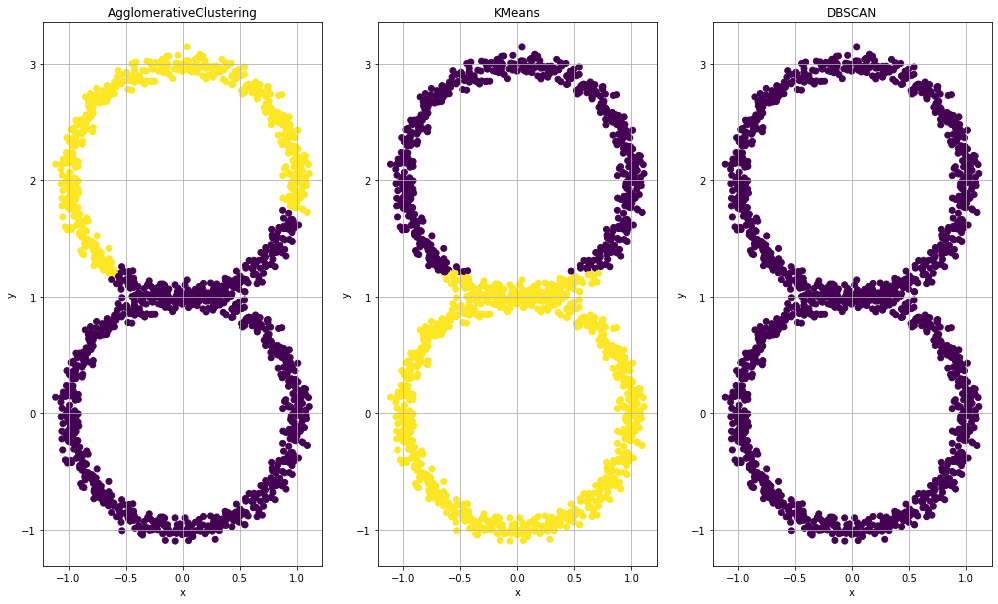

In [116]:
get_labels(curcle_df)
create_plot_for_clusters(curcle_df)

In [117]:
count_and_display_metrics(curcle_df, to_count_dbscan=False)

,silhouette score
AgglomerativeClustering,0.426297
KMeans,0.421661


DBSCAN сумел найти только один кластер, AgglomerativeClustering и KMeans примерно одинаковы. По моему мнению с опорой на график KMeans чуть лучше, по силуэту наоборот.

Вывод: DBSCAN, которому нельзя задать число кластеров, не слишком хорош, когда точки расположены примерно одинаково близко.

## Датасет в виде отрезка, пересекающего два круга.

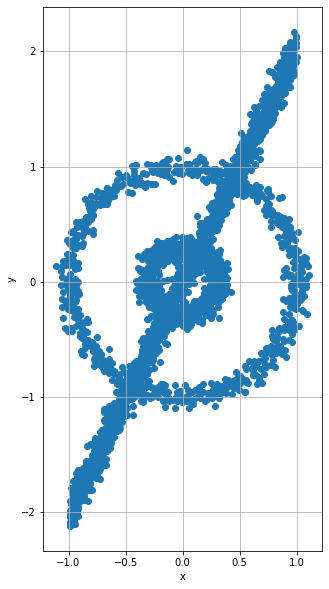

In [118]:
noisy_circles = datasets.make_circles(n_samples=N_SAMPLES, factor=0.3, noise=0.05, random_state=SEED)
df_1 = pd.DataFrame({'x': noisy_circles[0][:, 0], 'y': noisy_circles[0][:, 1], 'num': noisy_circles[1]}).drop(columns=['num'])

X, y = generate_samples_segment(to_do_shuffle=False)
df_2 = pd.DataFrame({'x': X[:, 0], 'y': y})

segments_and_circle_df = pd.concat([df_1, df_2], ignore_index=True)

create_plot_for_original_data(segments_and_circle_df)

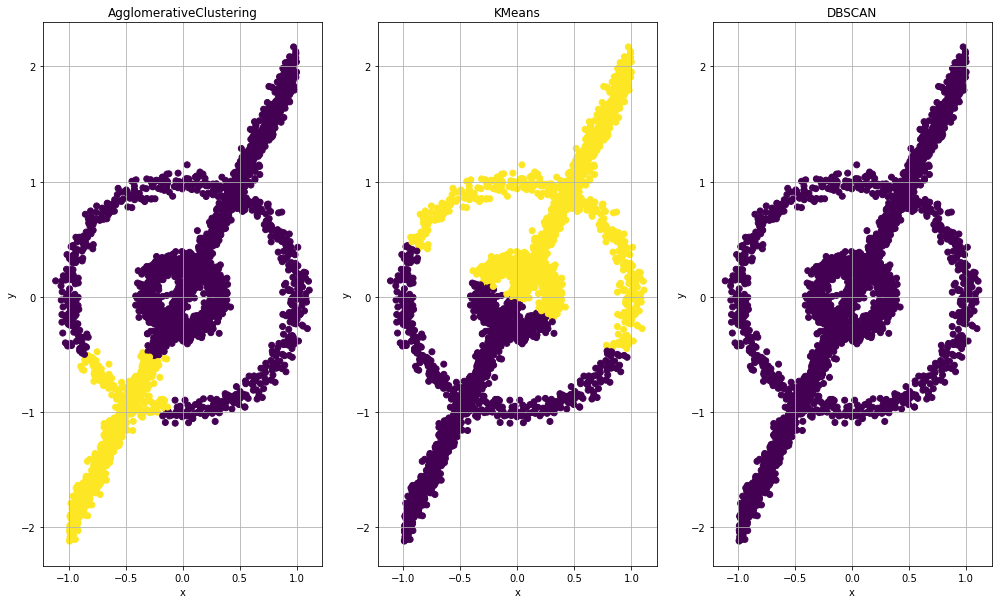

In [119]:
get_labels(segments_and_circle_df)
create_plot_for_clusters(segments_and_circle_df)

In [120]:
count_and_display_metrics(segments_and_circle_df, to_count_dbscan=False)

,silhouette score
AgglomerativeClustering,0.442618
KMeans,0.427974


DBSCAN сумел найти только один кластер, AgglomerativeClustering и KMeans примерно одинаковы. По моему мнению с опорой на график KMeans чуть лучше, по силуэту наоборот.

Вывод: DBSCAN, которому нельзя задать число кластеров, не слишком хорош, когда точки расположены примерно одинаково близко.

## Мой вариант датасета.

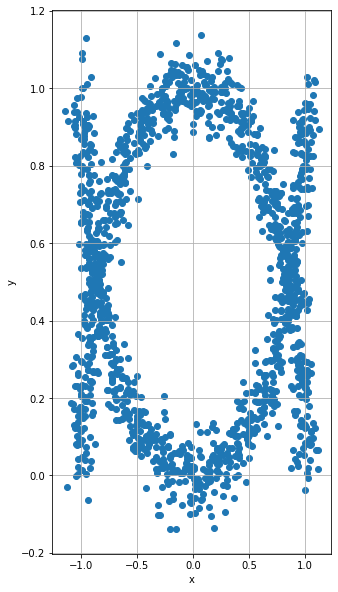

In [121]:
noisy_moons = datasets.make_moons(n_samples=N_SAMPLES, noise=0.05, random_state=SEED)
df = pd.DataFrame({'x': noisy_moons[0][:, 0], 'y': noisy_moons[0][:, 1], 'num': noisy_circles[1]})

first_moon_df = df[df['num'] == 0]
second_moon_df = df[df['num'] == 1]
second_moon_df.loc[:, 'x'] -= 1
second_moon_df.loc[:, 'y'] += 0.5

moon_df = pd.concat([first_moon_df, second_moon_df], ignore_index=True).drop(columns=['num'])

create_plot_for_original_data(moon_df)

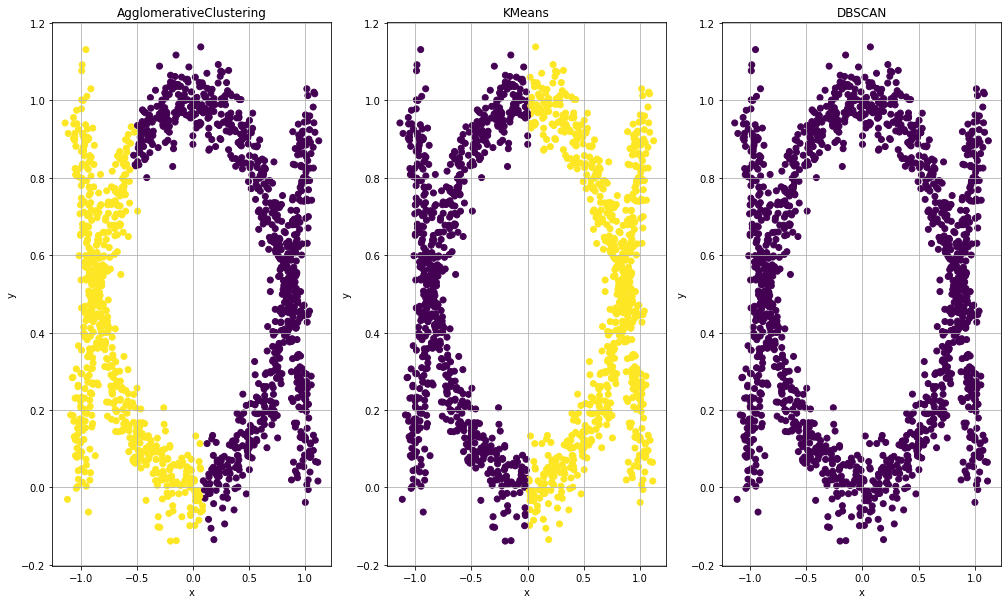

In [122]:
get_labels(moon_df)
create_plot_for_clusters(moon_df)

In [123]:
count_and_display_metrics(moon_df, to_count_dbscan=False)

,silhouette score
AgglomerativeClustering,0.503582
KMeans,0.553439


DBSCAN сумел найти только один кластер, AgglomerativeClustering и KMeans примерно одинаковы. Здесь мы с силуэтом сходимся во мнении, что KMeans отработал лучше.

Вывод: DBSCAN, которому нельзя задать число кластеров, не слишком хорош, когда точки расположены примерно одинаково близко.

## Еще мои варианты датасета - разное расстояние между лунами.

Далее подберем расстояния между лунами так, чтобы получались разные варианты кластеров (либо разрезанные пополам луны, либо две луны). Первым "сообразил" про две луны DBSCAN, затем KMeans и только потом AgglomerativeClustering. Силуэт на первом этапе отдавал первенство "разрезанным" лунам, правда, перевес был небольшой; но уже на втором этапе комбинация с двумя лунами "победила".

Вывод: в случае двух отдельных групп лучше всего работает DBSCAN.

*Для DBSCAN нужно хорошо подобрать eps - если значение слишком маленькое, то он выделит в отдельный кластер выброс, если большое, то найдет только один кластер.*

AgglomerativeClustering и KMeans "разрезали" обе луны на два цвета, DBSCAN "покрасил" каждую в свой цвет.

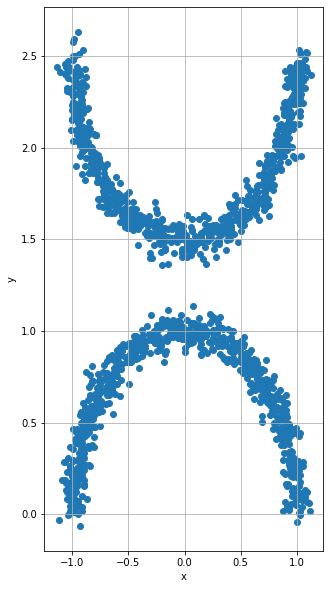

In [124]:
noisy_moons = datasets.make_moons(n_samples=N_SAMPLES, noise=0.05, random_state=SEED)
df = pd.DataFrame({'x': noisy_moons[0][:, 0], 'y': noisy_moons[0][:, 1], 'num': noisy_circles[1]})

first_moon_df = df[df['num'] == 0]
second_moon_df = df[df['num'] == 1]
second_moon_df.loc[:, 'x'] -= 1
second_moon_df.loc[:, 'y'] += 2

moon_2_y_df = pd.concat([first_moon_df, second_moon_df], ignore_index=True).drop(columns=['num'])

create_plot_for_original_data(moon_2_y_df)

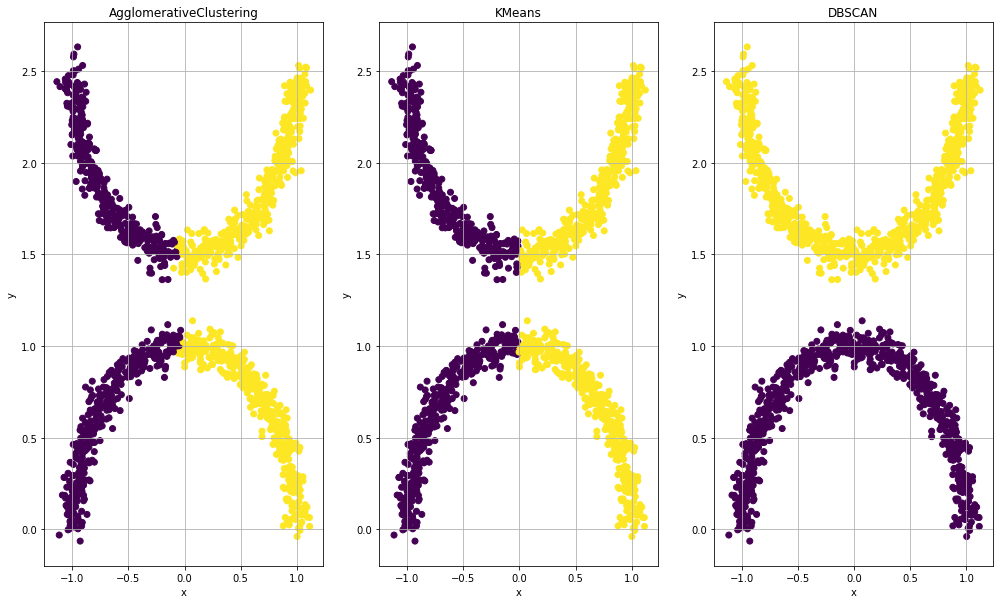

In [125]:
get_labels(moon_2_y_df)
create_plot_for_clusters(moon_2_y_df)

In [126]:
count_and_display_metrics(moon_2_y_df)

,silhouette score
AgglomerativeClustering,0.397479
KMeans,0.397559
DBSCAN,0.382946


AgglomerativeClustering "разрезал" обе луны на два цвета, KMeans и DBSCAN "покрасили" каждую в свой цвет.

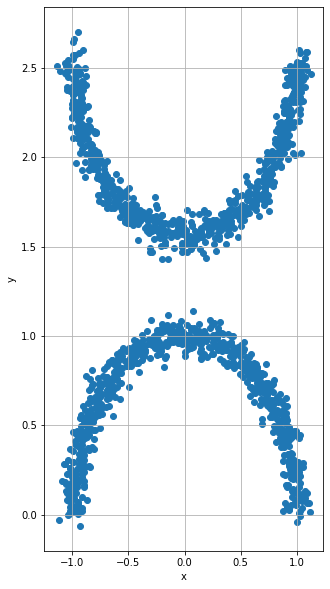

In [127]:
noisy_moons = datasets.make_moons(n_samples=N_SAMPLES, noise=0.05, random_state=SEED)
df = pd.DataFrame({'x': noisy_moons[0][:, 0], 'y': noisy_moons[0][:, 1], 'num': noisy_circles[1]})

first_moon_df = df[df['num'] == 0]
second_moon_df = df[df['num'] == 1]
second_moon_df.loc[:, 'x'] -= 1
second_moon_df.loc[:, 'y'] += 2.07

moon_2_07_y_df = pd.concat([first_moon_df, second_moon_df], ignore_index=True).drop(columns=['num'])

create_plot_for_original_data(moon_2_07_y_df)

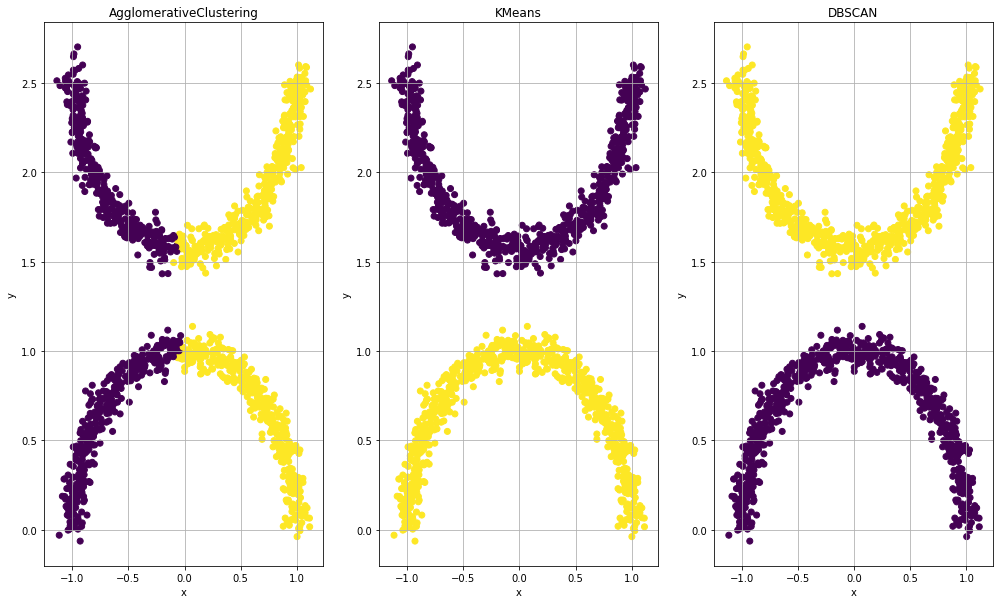

In [128]:
get_labels(moon_2_07_y_df)
create_plot_for_clusters(moon_2_07_y_df)

In [129]:
count_and_display_metrics(moon_2_07_y_df)

,silhouette score
AgglomerativeClustering,0.386224
KMeans,0.406566
DBSCAN,0.406566


Все три алгоритма разделили на две луны.

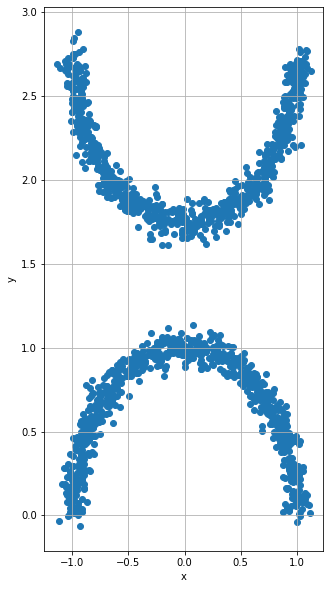

In [130]:
noisy_moons = datasets.make_moons(n_samples=N_SAMPLES, noise=0.05, random_state=SEED)
df = pd.DataFrame({'x': noisy_moons[0][:, 0], 'y': noisy_moons[0][:, 1], 'num': noisy_circles[1]})

first_moon_df = df[df['num'] == 0]
second_moon_df = df[df['num'] == 1]
second_moon_df.loc[:, 'x'] -= 1
second_moon_df.loc[:, 'y'] += 2.25

moon_2_25_y_df = pd.concat([first_moon_df, second_moon_df], ignore_index=True).drop(columns=['num'])

create_plot_for_original_data(moon_2_25_y_df)

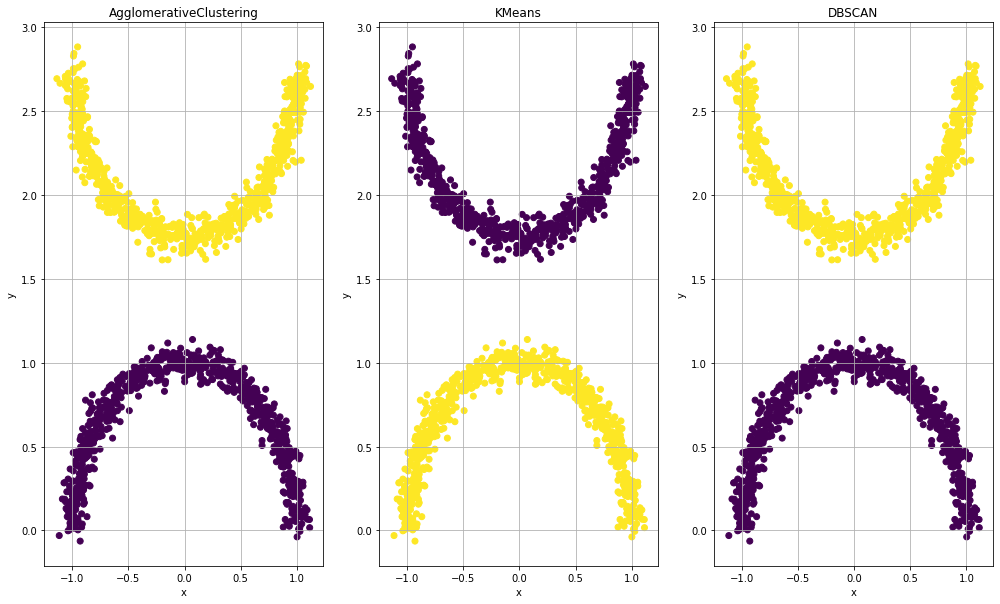

In [131]:
get_labels(moon_2_25_y_df)
create_plot_for_clusters(moon_2_25_y_df)

In [132]:
count_and_display_metrics(moon_2_25_y_df)

,silhouette score
AgglomerativeClustering,0.460903
KMeans,0.460903
DBSCAN,0.460903
